# Tecnológico de Monterrey

## MR4010 Navegación autónoma

## Profesor titular: Dr. David Antonio-Torres
## Profesor tutor: Dr. Rafael Mendoza Crespo

### Actividad 2.1 - Detección de carriles en video usando transformada de Hough

#### Emmanuel Domínguez Bravo A01793683
#### Maximiliano Morones Gómez A01793815
#### Saúl Yovani Salgueiro Lindoro A01633510
#### Gerardo Quiroga Nájera A00967999

In [2]:
# Se cargan las bibliotecas necesarias

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2


PRIMER FRAME EN ESCALA DE GRISES Y DETECCIÓN DE BORDES

En este primer bloque de código vamos a leer nuestro video de carretera (test.mp4), primero vamos a obtener el primer fotograma o-frame- que usaremos para definir nuestro ROI, nuestra región de interés. Para ello y convertir en escalas de grises, vamos a cambiar la imagen de BGR a RGB, después de este cambio, mandamos el resultado a escalas de grises a la variable img_grey. Después se detectan los border con la función Canny de OpenCV y la almacenamos en la variable img_canny, finalmente, nuestra imgen a escala de grises, se convierte en un arreglo numpy. mostramos el primer frame RGB de nuestro video.

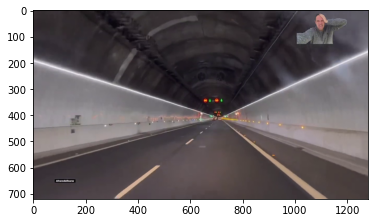

In [3]:
# Se carga el archivo MP4 
cap = cv2.VideoCapture('test.MP4')

# Se accede a uno de los frames para mostrar la imagen que usaremos para definir la ROI

ret, frame = cap.read()
image = frame
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_canny = cv2.Canny(img_grey, 40, 120) 
img_arr = np.asarray(img_grey)
plt.imshow(frame_rgb, cmap='gray')

DEFINICIÓN DE LA ROI

La variable ROI_vertices contiene un arreglo de puntos que definen las coordenadas de los vértices de un polígono que se utilizará como máscara para la ROI. En este caso, se define en las siguientes coordenadas(0,720), (200, 450), (700, 350) y (1200,720) y que se pueden apreciar, aproximadamente, en el resultado del primer bloque de código.
Al final y con la operación AND entre las imágenes de escala a grises, que obtuvimos en el paso anterior y la imagen máscara de este bloque, comparamos ambas imágenes, esto implica que, para cada píxel de ambas imágenes, si ambos son distintos de cero (es decir, si pertenecen a la región de interés), se mantendrán en la imagen resultante. De lo contrario, se establecerán en cero y aparecerán como negro.

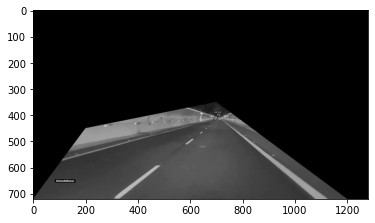

In [4]:
# Definimos la ROI
ROI_vertices = np.array([[(0,720),(200, 450), (700, 350), (1200,720)]], dtype=np.int32)

img_roi = np.zeros_like(img_grey)
cv2.fillPoly(img_roi, ROI_vertices, 255)
img_con_roi = cv2.bitwise_and(img_grey, img_roi)
plt.imshow(img_con_roi, cmap='gray')

PROCESAMIENTO DE LA IMAGEN 

El siguiente bloque de código implementa una función llamada process(image) que procesa una imagen para detectar las líneas de carril en una carretera. Primero, se convierte la imagen a escala de grises y se obtienen los bordes utilizando la técnica de detección de bordes de Canny. Luego, se define una región de interés utilizando un polígono y se aplica esta región a los bordes detectados.

A continuación, se utiliza la Transformada de Hough para encontrar las líneas en la imagen que se encuentran dentro de la región de interés. Las líneas detectadas se dibujan en una imagen negra y luego se combina con la imagen original utilizando la función cv2.addWeighted(). En nuestro caso estuvimos experimentando prueba-error con el threshold de 100 a 50, siendo 50 el mejor para nuestro video.

La imagen resultante muestra la imagen original con las líneas de carril detectadas resaltadas en color rojo.
La función devuelve la imagen procesada con las líneas de carril resaltadas.

In [5]:
# Creamos una función con el proceso completo de generación de las líneas de detección de los carriles

def process(image):

    # Se cargan los frames del video en escala de grises y se obtienen los bordes con *Canny*
    
    img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_canny = cv2.Canny(img_grey, 200, 400) 

    # Se crea la ROI
    ROI_vertices = np.array([[(0,720),(200, 450), (700, 350), (1200,720)]], dtype=np.int32)
    
    # Se aplica la ROI al frame en escala de grises que resulta de aplicar Canny
    
    img_roi = np.zeros_like(img_canny)
    cv2.fillPoly(img_roi, ROI_vertices, 255)
    img_mask = cv2.bitwise_and(img_canny, img_roi)
    
    rho = 2            # resolución de rho en pixeles
    theta = np.pi/180  # resolución de theta en radianes 
    threshold = 50     # mínimo número de votos para ser considerado una línea 
    min_line_len = 1  # mínimo número de pixeles para que se forme una línea
    max_line_gap = 40  # máximo espacio en pixeles entre segmentos de línea    
    lines = cv2.HoughLinesP(img_mask, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    
    # se crea un fondo negro del tamaño de la imagen con bordes
    img_lines = np.zeros((img_mask.shape[0], img_mask.shape[1], 3), dtype=np.uint8)
    # se dibujan cada una de las líneas sobre la imagen con fondo negro    
    
    for line in lines:
        for x1,y1,x2,y2 in line:      
            cv2.line(img_lines, (x1, y1), (x2, y2), [255, 0, 0], 30)
        
    #Usando la función *addWeighted* se hace una combinación de la imagen a color original y las
    #líneas encontradas por la Transformada de Hough
    alpha = 1
    beta = 1
    gamma = 1
    img_lane_lines = cv2.addWeighted(image, alpha, img_lines, beta, gamma)
    
    return img_lane_lines




RESULTADO FINAL
En este último bloque, vamos a llamar a nuestra función 'process' a cada frame para imprimir los carriles en el video resultado, los valores de altura y ancho son los mismos que nuestro video muestra.
En el ciclo While, itera sobre cada uno de los frames, los cuales los manda a la función 'process' para identificar los carriles e identificarlos, cuando se termine el video o se presione barra, el proceso termina.
En nuestro caso estuvimos buscando una solución a cerrar el video de manera automática incluyendo una instrucción final 4 veces.

In [8]:
# Se carga el archivo MP4 y se accede a cada uno de los frames.
# Iteramos el proceso de graficar las líneas sobre cada frame.

cap = cv2.VideoCapture('test.MP4')
width = 1000
height = 600

while True:
    ret, frame = cap.read()
    if ret:
        frame = cv2.resize (frame, (width, height))
        frame = process(frame)
        cv2.imshow('video', frame)
        if cv2.waitKey(1) == 13:
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)

-1